In [ ]:
%%capture
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
!pip install ipython-autotime

%load_ext autotime
exit() # restart the runtime to refresh installed pkg

time: 636 µs (started: 2023-06-18 18:11:01 +00:00)


In [ ]:
from bigdl.chronos.data import TSDataset
from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time

import json
from json import loads
import time
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
def preprocessing(df):
  df1 = pd.DataFrame()
  df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-06-16' )
  df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                            if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
  # xử lý missing
  df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear').fillna(method='bfill')
  df1['Product_weight'] = df1['Product_weight']/1000
  return df1

In [ ]:
#df1:cod, df2: haddock, df3: halibut
df = pd.read_csv('/content/NortheastArcticCod.csv',parse_dates=['Last_catch_date'])
df1 = preprocessing(df)
df = pd.read_csv('/content/NortheastArcticHaddock.csv',parse_dates=['Last_catch_date'])
df2 = preprocessing(df)
df = pd.read_csv('/content/AtlanticHalibut.csv',parse_dates=['Last_catch_date'])
df3 = preprocessing(df)
del df

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 90
horizon = 30
train,val,test = split_train_val_test(df3, train_size = 0.6, val_size = 0.2, test_size = 0.2)

scaler = StandardScaler()
train['Product_weight'] = scaler.fit_transform(train['Product_weight'].values.reshape(-1,1))
val['Product_weight'] = scaler.transform(val['Product_weight'].values.reshape(-1,1))
test['Product_weight'] = scaler.transform(test['Product_weight'].values.reshape(-1,1))

X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)
X_Ndays = test.iloc[-lookback:,1].values.reshape(1,-1)

X_Ndays_unscale = scaler.inverse_transform(X_Ndays)
X_val_unscale = scaler.inverse_transform(X_val)
X_test_unscale = scaler.inverse_transform(X_test)
X_train_unscale = scaler.inverse_transform(X_train)

y_train_unscale = scaler.inverse_transform(y_train)
y_val_unscale = scaler.inverse_transform(y_val)
y_test_unscale = scaler.inverse_transform(y_test)


X_train = np.expand_dims(X_train,axis=-1)
X_val = np.expand_dims(X_val,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

y_train = np.expand_dims(y_train,axis=-1)
y_val = np.expand_dims(y_val,axis=-1)
y_test = np.expand_dims(y_test,axis=-1)

In [ ]:
from sklearn.metrics import *

def get_metrics(g,p,model_name):
  mse = mean_squared_error(g,p)
  rmse = np.sqrt(mean_squared_error(g,p))
  mae = mean_absolute_error(g,p)
  mape = mean_absolute_percentage_error(g,p)
  r2 = r2_score(g,p)
  print('Kết quả đánh giá:')
  print('MSE:',mse)
  print('RMSE:',rmse)
  print('MAE:',mae)
  print('MAPE:',mape)
  print('R2:',r2)
  return {model_name:[mse,rmse,mae,mape,r2]}

In [ ]:
import torch
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
import matplotlib.pyplot as plt

def visualize(test,X_test_unscale,y_test_unscale,pred_30days_unscale):
    plt.figure(figsize=(16,9))
    tmp0 = pd.DataFrame()
    tmp0['Date'] = test['Date'][-120:-30]
    tmp0['w'] = X_test_unscale[-1]

    tmp1 = pd.DataFrame()
    tmp1['Date'] = test['Date'][-30:]
    tmp1['gt'] = y_test_unscale[-1,:]
    tmp1['pd'] = pred_test_unscale[-1,:]

    tmp2 = pd.DataFrame()
    tmp2['Date'] = pd.date_range(start = test['Date'].iloc[-1] + pd.DateOffset(days=1) , end = test['Date'].iloc[-1] + pd.DateOffset(days=30))
    tmp2['30'] = pred_30days_unscale[-1,:]

    a = tmp0.set_index('Date').copy()
    b = tmp1[['Date','gt']].set_index('Date')
    c = tmp2[['Date','30']].set_index('Date')

    new_cols = {x: y for x, y in zip(b.columns, a.columns)}
    a = a.append(b.rename(columns=new_cols))
    new_cols = {x: y for x, y in zip(c.columns, a.columns)}
    a = a.append(c.rename(columns=new_cols))
    plt.plot(a,'r-', alpha=0.7,label='_nolegend_')
    plt.plot(tmp0.set_index('Date'))
    plt.plot(tmp1.set_index('Date')['gt'])
    plt.plot(tmp1.set_index('Date')['pd'])
    plt.plot(tmp2.set_index('Date')['30'])
    plt.legend(['Last 90 days','30 days groundtruth','30 days predicted','Next 30 days'], prop={'size': 20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

### Seq2Seq

In [ ]:
set_seed()
feature_dim = X_train.shape[-1] # 1, số feature đầu vào (chỉ product weight của 90 ngày trước)
target_dim = y_train.shape[-1] # số feature đầu ra, (chỉ thuoc tinh product weight 30 ngày tiếp theo)
learning_rate = 0.0001
drop = 0

#cod:[64]*2
#haddock: [64]*2
#halibut:[64]*2

seq2seqforecaster = Seq2SeqForecaster(past_seq_len=lookback,
                              future_seq_len = horizon,
                              input_feature_num=feature_dim,
                              output_feature_num=target_dim,
                              lstm_hidden_dim=64,
                              lstm_layer_num=2,
                              lr=learning_rate,
                              loss='mse',
                              seed=42,
                              metrics = 'rmse',
                              dropout=drop,
                              optimizer='Adam',
                              normalization=False,
                              )

In [ ]:
batch_size = 64
epochs = 5
seq2seqforecaster.fit(data=(X_train.astype('float32'), y_train.astype('float32')),
                  validation_data =(X_val.astype('float32'),y_val.astype('float32')),
                  batch_size = batch_size,
                  epochs = epochs)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'0': {'val_loss': '1.4303427934646606'},
 '1': {'val_loss': '1.3598119020462036'},
 '2': {'val_loss': '1.227602243423462'},
 '3': {'val_loss': '1.2153345346450806'},
 '4': {'val_loss': '1.2146122455596924'}}

In [ ]:
pred_val = seq2seqforecaster.predict(X_val.astype('float32'))[:,:,0]
pred_test = seq2seqforecaster.predict(X_test.astype('float32'))[:,:,0]

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'Seq2Seq')

print('\nTest set')
seq2seq_re = get_metrics(pred_test_unscale,y_test_unscale,'Seq2Seq')


Validation set
Kết quả đánh giá:
MSE: 29428.949186501985
RMSE: 171.54867876641308
MAE: 122.57072989104913
MAPE: 0.592755585157733
R2: -6.936284724476695

Test set
Kết quả đánh giá:
MSE: 34447.92067467967
RMSE: 185.6015104321074
MAE: 118.99592596642043
MAPE: 0.656582736076998
R2: -4.178760154735186


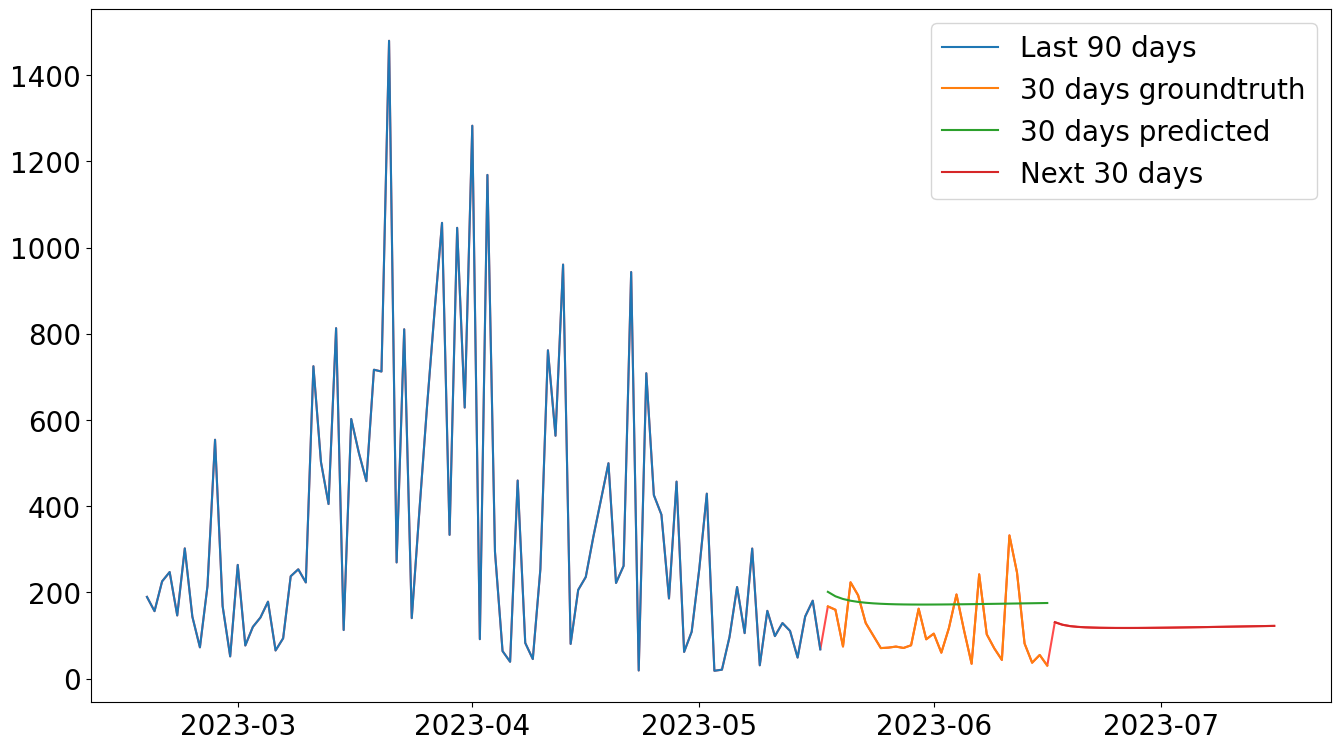

In [ ]:
pred_Ndays = seq2seqforecaster.predict(np.expand_dims(X_Ndays,axis=-1).astype('float32'))[:,:,0]
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_Ndays_unscale)

### TCN

In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster

set_seed()
feature_dim = X_train.shape[-1] # 1, số feature đầu vào (chỉ product weight của 90 ngày trước)
target_dim =  y_train.shape[-1] # số feature đầu ra, (chỉ product weight 30 ngày tiếp theo)
learning_rate = 0.0001
drop = 0
#cod:[64]*3
#haddock: [64]*2
#halibut:[64]*4
tcnforecaster = TCNForecaster(past_seq_len=lookback,
                              future_seq_len = horizon,
                              input_feature_num=feature_dim,
                              output_feature_num=target_dim,
                              lr=learning_rate,
                              loss='mse',
                              seed=42,
                              metrics = 'rmse',
                              kernel_size=3,
                              dropout=drop,
                              num_channels = [64]*2,
                              optimizer='Adam',
                              normalization=False
                              )

In [ ]:
batch_size = 64
epochs = 5
tcnforecaster.fit(data=(X_train.astype('float32'), y_train.astype('float32')),
                  validation_data =(X_val.astype('float32'),y_val.astype('float32')),
                  batch_size = batch_size,
                  epochs = epochs)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'0': {'val_loss': '2.061527729034424'},
 '1': {'val_loss': '1.8523155450820923'},
 '2': {'val_loss': '1.6915485858917236'},
 '3': {'val_loss': '1.873800277709961'},
 '4': {'val_loss': '1.468113660812378'}}

In [ ]:
pred_val = tcnforecaster.predict(X_val.astype('float32'))[:,:,0]
pred_test = tcnforecaster.predict(X_test.astype('float32'))[:,:,0]

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)


print('\nValidation set')
get_metrics(pred_val_unscale,y_val_unscale,'TCN')

print('\nTest set')
tcn_re = get_metrics(pred_test_unscale,y_test_unscale,'TCN')


Validation set
Kết quả đánh giá:
MSE: 18.446463954719327
RMSE: 4.2949346857338035
MAE: 2.8817431101888564
MAPE: 0.694313943361103
R2: -7.321492310887636

Test set
Kết quả đánh giá:
MSE: 25.66340945039058
RMSE: 5.065906577345321
MAE: 3.4494649344066066
MAPE: 0.6193157069407061
R2: -4.385257327046165


In [ ]:
pred_Ndays = tcnforecaster.predict(np.expand_dims(X_Ndays,axis=-1).astype('float32'))[:,:,0]
pred_Ndays_unscale = scaler.inverse_transform(pred_Ndays)
visualize(test,X_test_unscale,y_test_unscale,pred_Ndays_unscale)

### Summary

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

re_ = [seq2seq_re,tcn_re]
all_re = {}
for r in re_:
  all_re.update(r)

results = pd.DataFrame(all_re)
results.index = ['MSE','RMSE','MAE','MAPE','R2']
results.T

,MSE,RMSE,MAE,MAPE,R2
Seq2Seq,34328.16020500,185.27860158,116.62650245,0.67218017,-5.87615290
TCN,38122.49157547,195.24981837,120.40847637,0.80784005,-7.59338147
